In [1]:
import gc
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, CatBoostRegressor
import lightgbm as lgb
from tqdm import tqdm

import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df_train1 = pd.read_csv('train1.csv', dtype={'server_model': 'str',
                                             'last_msg_id': 'str',
                                             'last_template_id': 'str'})
df_test1 = pd.read_csv('test1.csv', dtype={'server_model': 'str',
                                           'last_msg_id': 'str',
                                           'last_template_id': 'str'})

df_train2 = pd.read_csv('train2.csv', dtype={'tmp_appearance_1': 'str',
                                             'tmp_appearance_2': 'str',
                                             'tmp_appearance_3': 'str',
                                             'msg_appearance_1': 'str',
                                             'msg_appearance_2': 'str',
                                             'msg_appearance_3': 'str',
                                             'max_continuous_msg': 'str'})
df_test2 = pd.read_csv('test2.csv', dtype={'tmp_appearance_1': 'str',
                                           'tmp_appearance_2': 'str',
                                           'tmp_appearance_3': 'str',
                                           'msg_appearance_1': 'str',
                                           'msg_appearance_2': 'str',
                                           'msg_appearance_3': 'str',
                                           'max_continuous_msg': 'str'})

df_train3 = pd.read_csv('train3.csv')
df_test3 = pd.read_csv('test3.csv')

df_train4 = pd.read_csv('train4.csv')
df_test4 = pd.read_csv('test4.csv')

df_train5 = pd.read_csv('train5.csv')
df_test5 = pd.read_csv('test5.csv')

df_train6 = pd.read_csv('train_helper.csv')
df_test6 = pd.read_csv('test_helper.csv')

df_train = pd.merge(df_train1, df_train2, on=['sn', 'fault_time', 'label'])\
    .merge(df_train3, on=['sn', 'fault_time', 'label'])\
    .merge(df_train4, on=['sn', 'fault_time', 'label'])\
    .merge(df_train5, on=['sn', 'fault_time', 'label'])\
    .merge(df_train6, on=['sn', 'fault_time', 'label'])
df_test = pd.merge(df_test1, df_test2, on=['sn', 'fault_time'])\
    .merge(df_test3, on=['sn', 'fault_time'])\
    .merge(df_test4, on=['sn', 'fault_time'])\
    .merge(df_test5, on=['sn', 'fault_time'])\
    .merge(df_test6, on=['sn', 'fault_time'])

In [3]:
df_train.shape, df_test.shape

((16604, 124), (3030, 123))

In [4]:
bert_train = pd.read_csv('../bert/train.csv')
bert_test = pd.read_csv('../bert/test_b.csv')

df_train = pd.concat([df_train, bert_train.iloc[:, 9:]], axis=1)
df_test = pd.concat([df_test, bert_test.iloc[:, 9:]], axis=1)

# df_train = df_train.merge(bert_train, on=['sn', 'fault_time', 'label'])
# df_test = df_test.merge(bert_test, on=['sn', 'fault_time'])

In [5]:
df_train.shape, df_test.shape

((16604, 508), (3030, 507))

In [6]:
classes = np.unique(df_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = dict(zip(classes, weights))

In [7]:
def macro_f1(y_true, y_pred) -> float:
    """
    计算得分
    :param target_df: [sn,fault_time,label]
    :param submit_df: [sn,fault_time,label]
    :return:
    """
    weights =  [3  /  7,  2  /  7,  1  /  7,  1  /  7]
    overall_df = pd.DataFrame([y_true, y_pred]).T
    overall_df.columns = ['label_gt', 'label_pr']

    macro_F1 =  0.
    for i in  range(len(weights)):
        TP =  len(overall_df[(overall_df['label_gt'] == i) & (overall_df['label_pr'] == i)])
        FP =  len(overall_df[(overall_df['label_gt'] != i) & (overall_df['label_pr'] == i)])
        FN =  len(overall_df[(overall_df['label_gt'] == i) & (overall_df['label_pr'] != i)])
        precision = TP /  (TP + FP)  if  (TP + FP)  >  0  else  0
        recall = TP /  (TP + FN)  if  (TP + FP)  >  0  else  0
        F1 =  2  * precision * recall /  (precision + recall)  if  (precision + recall)  >  0  else  0
        macro_F1 += weights[i]  * F1
    return macro_F1

In [8]:
for name in ['last_msg_id', 'last_template_id', 'tmp_appearance_1', 'tmp_appearance_2', 'tmp_appearance_3',
             'msg_appearance_1', 'msg_appearance_2', 'msg_appearance_3', 'max_continuous_msg']:
    df_train[name] = df_train[name].fillna('NULL')
    df_test[name] = df_test[name].fillna('NULL')

In [9]:
NUM_CLASSES = df_train['label'].nunique()
FOLDS = 10
TARGET = 'label'
use_features = [col for col in df_train.columns if col not in ['sn', 'fault_time', TARGET]]

def run_ctb(df_train, df_test, use_features):
    target = TARGET
    oof_pred = np.zeros((len(df_train), NUM_CLASSES))
    y_pred = np.zeros((len(df_test), NUM_CLASSES))
    
    folds = GroupKFold(n_splits=FOLDS)
    for fold, (tr_ind, val_ind) in enumerate(folds.split(df_train, df_train[TARGET], df_train['sn'])):
        print(f'Fold {fold + 1}')
        x_train, x_val = df_train[use_features].iloc[tr_ind], df_train[use_features].iloc[val_ind] 
        y_train, y_val = df_train[target].iloc[tr_ind], df_train[target].iloc[val_ind]

        params = { 
            'task_type': 'CPU',
            'bootstrap_type': 'Bernoulli',
            'learning_rate': 0.03, 
            'eval_metric': 'MultiClass', 
            'loss_function': 'MultiClass', 
            'classes_count': NUM_CLASSES, 
            'iterations': 10000,
            'random_state': 42,
            'depth': 8,
            'leaf_estimation_iterations': 8,
            'reg_lambda': 5,
            'subsample': 0.8,
            'class_weights': class_weights,
            'early_stopping_rounds': 100,
            'cat_features': ['server_model', 'last_msg_id', 'last_template_id',
                             'tmp_appearance_1', 'tmp_appearance_2', 'tmp_appearance_3',
                             'msg_appearance_1', 'msg_appearance_2', 'msg_appearance_3',
                             'max_continuous_msg'],
        }
        model = CatBoostClassifier(**params)
        
        model.fit(x_train, 
                  y_train, 
                  eval_set=(x_val, y_val), 
                  verbose=100) 
        oof_pred[val_ind] = model.predict_proba(x_val) 
        y_pred += model.predict_proba(df_test[use_features]) / folds.n_splits
        
        score = f1_score(y_val, oof_pred[val_ind].argmax(axis=1), average='macro')
        print(f'F1 score: {score}')
        
        print("Features importance...")
        feat_imp = pd.DataFrame({'imp': model.feature_importances_, 'feature': use_features})
        feat_imp.sort_values(by='imp').to_csv('%d_imp.csv'%fold, index=False)
        print(feat_imp.sort_values(by='imp').reset_index(drop=True))
        
        del x_train, x_val, y_train, y_val
        gc.collect()
        
    return y_pred, oof_pred

In [ ]:
y_pred, oof_pred = run_ctb(df_train, df_test, use_features)

Fold 1
0:	learn: 1.3399645	test: 1.3408930	best: 1.3408930 (0)	total: 388ms	remaining: 1h 4m 38s
100:	learn: 0.5033753	test: 0.6005781	best: 0.6005781 (100)	total: 34.9s	remaining: 57m
200:	learn: 0.4017043	test: 0.5621035	best: 0.5619814 (197)	total: 1m 8s	remaining: 56m 3s
300:	learn: 0.3364410	test: 0.5498549	best: 0.5498549 (300)	total: 1m 43s	remaining: 55m 26s
400:	learn: 0.2873271	test: 0.5449609	best: 0.5449596 (397)	total: 2m 17s	remaining: 54m 44s
500:	learn: 0.2520669	test: 0.5452049	best: 0.5438151 (457)	total: 2m 51s	remaining: 54m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5438150871
bestIteration = 457

Shrink model to first 458 iterations.
F1 score: 0.7351123329577273
Features importance...
          imp             feature
0    0.000000                  76
1    0.000000  max_continuous_msg
2    0.000000                 375
3    0.000000                 259
4    0.000000                 285
..        ...                 ...
500  2.540963    

100:	learn: 0.5070392	test: 0.5862482	best: 0.5862482 (100)	total: 34.8s	remaining: 56m 45s
200:	learn: 0.4003396	test: 0.5410818	best: 0.5410790 (199)	total: 1m 8s	remaining: 55m 51s
300:	learn: 0.3349448	test: 0.5260485	best: 0.5260248 (298)	total: 1m 42s	remaining: 55m 13s
400:	learn: 0.2863592	test: 0.5190176	best: 0.5188321 (397)	total: 2m 16s	remaining: 54m 34s
500:	learn: 0.2479585	test: 0.5194949	best: 0.5184702 (431)	total: 2m 50s	remaining: 53m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5184701975
bestIteration = 431

Shrink model to first 432 iterations.
F1 score: 0.7650669023317681
Features importance...
          imp           feature
0    0.000000               113
1    0.000000            w2v_27
2    0.000000            w2v_63
3    0.000000               169
4    0.000000               207
..        ...               ...
500  2.603921                20
501  2.875127  last_template_id
502  4.883511      server_model
503  5.317208             

In [14]:
print(macro_f1(df_train[TARGET], np.argmax(oof_pred, axis=1)))

0.6623244421486119


In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(df_train[TARGET], np.argmax(oof_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.46      0.47      1476
           1       0.72      0.71      0.72      3387
           2       0.96      0.93      0.95      9320
           3       0.81      0.91      0.86      2421

    accuracy                           0.84     16604
   macro avg       0.74      0.76      0.75     16604
weighted avg       0.85      0.84      0.84     16604



In [17]:
submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

sub = submit_df[['sn', 'fault_time']].copy()
sub['label'] = y_pred.argmax(axis=1)
display(sub.head())
sub['label'].value_counts() / sub.shape[0]

,sn,fault_time,label
0,0015fe530ad4,2020-05-01 23:48:17,2
1,00380f1435b0,2020-07-28 07:51:13,3
2,0045a71d0221,2020-07-02 06:33:54,1
3,004d5a7954e7,2020-08-24 08:27:55,2
4,004d5a7954e7,2020-08-24 09:42:45,0


2    0.522112
3    0.208911
1    0.184818
0    0.084158
Name: label, dtype: float64

In [18]:
label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

label_df['label'].value_counts() / label_df.shape[0]

2    0.561311
1    0.203987
3    0.145808
0    0.088894
Name: label, dtype: float64

In [19]:
sub.to_csv('baseline3_gkf_sn.csv', index=False)

In [47]:
label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

In [48]:
submit_df = pd.read_csv('../data/preliminary_submit_dataset_a.csv')

In [49]:
log_df = pd.read_csv('./log_template.csv')

In [50]:
log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

In [51]:
label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')

In [52]:
train_pred = np.argmax(oof_pred, axis=1)

In [133]:
len(zero_idx)

1476

In [68]:
right_idx = []
for i in range(train_pred.shape[0]):
    if train_pred[i] == df_train[TARGET][i] and train_pred[i] == 0:
        right_idx.append(i)

In [69]:
error_idx = []
for i in range(train_pred.shape[0]):
    if train_pred[i] != df_train[TARGET][i] and train_pred[i] == 1 and df_train[TARGET][i] == 0:
        error_idx.append(i)

In [74]:
df_train.iloc[right_idx].shape

(679, 499)

In [75]:
df_train.iloc[error_idx].shape

(666, 499)

In [85]:
df_train.columns.tolist()

['sn',
 'fault_time',
 'server_model',
 'last_msg_id',
 'last_template_id',
 'cnt_2h',
 'percent_2h',
 'msg_nunique_2h',
 'template_nunique_2h',
 'msg_percent_2h',
 'template_percent_2h',
 'template_to_msg_percent_2h',
 'msg_to_msg_percent_2h',
 'template_to_template_percent_2h',
 'second_span_2h',
 'time_diffs_avg_2h',
 'time_diffs_max_2h',
 'time_diffs_min_2h',
 'time_diffs_std_2h',
 'label',
 'appearance_1',
 'appearance_1_percent',
 'appearance_2',
 'appearance_2_percent',
 'appearance_3',
 'appearance_3_percent',
 'w2v_0',
 'w2v_1',
 'w2v_2',
 'w2v_3',
 'w2v_4',
 'w2v_5',
 'w2v_6',
 'w2v_7',
 'w2v_8',
 'w2v_9',
 'w2v_10',
 'w2v_11',
 'w2v_12',
 'w2v_13',
 'w2v_14',
 'w2v_15',
 'w2v_16',
 'w2v_17',
 'w2v_18',
 'w2v_19',
 'w2v_20',
 'w2v_21',
 'w2v_22',
 'w2v_23',
 'w2v_24',
 'w2v_25',
 'w2v_26',
 'w2v_27',
 'w2v_28',
 'w2v_29',
 'w2v_30',
 'w2v_31',
 'w2v_32',
 'w2v_33',
 'w2v_34',
 'w2v_35',
 'w2v_36',
 'w2v_37',
 'w2v_38',
 'w2v_39',
 'w2v_40',
 'w2v_41',
 'w2v_42',
 'w2v_43',
 '

In [78]:
import seaborn as sns

/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='second_span_2h', ylabel='Density'>

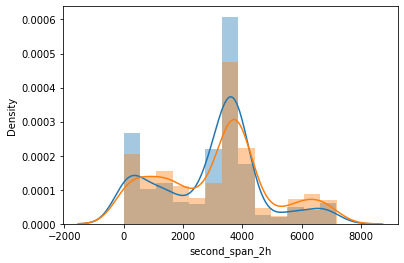

In [123]:
sns.distplot(df_train.iloc[right_idx]['second_span_2h'])
sns.distplot(df_train.iloc[error_idx]['second_span_2h'])

In [108]:
zero_idx = []
for i in range(train_pred.shape[0]):
    if df_train[TARGET][i] == 0:
        zero_idx.append(i)

In [109]:
one_idx = []
for i in range(train_pred.shape[0]):
    if df_train[TARGET][i] == 1:
        one_idx.append(i)

In [111]:
two_idx = []
for i in range(train_pred.shape[0]):
    if df_train[TARGET][i] == 2:
        two_idx.append(i)

In [112]:
three_idx = []
for i in range(train_pred.shape[0]):
    if df_train[TARGET][i] == 3:
        three_idx.append(i)

/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='second_span_2h', ylabel='Density'>

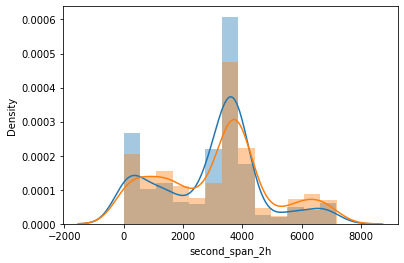

In [124]:
sns.distplot(df_train.iloc[right_idx]['second_span_2h'])
sns.distplot(df_train.iloc[error_idx]['second_span_2h'])

/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='second_span_2h', ylabel='Density'>

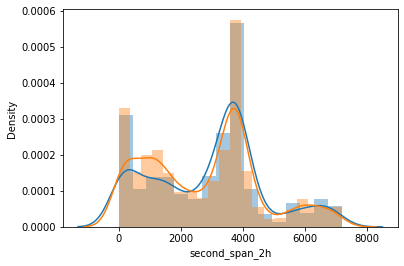

In [125]:
sns.distplot(df_train.iloc[zero_idx]['second_span_2h'])
sns.distplot(df_train.iloc[one_idx]['second_span_2h'])

In [116]:
label_df[label_df['label'] == 1]

,sn,fault_time,label,fault_time_ts,server_model
1122,SERVER_12,2020-06-11 11:45:00,1,1591875900,SM3
1146,SERVER_588,2020-03-19 05:33:00,1,1584595980,SM6
1150,SERVER_437,2020-01-25 05:14:00,1,1579929240,SM6
1155,SERVER_567,2020-07-22 06:08:00,1,1595398080,SM6
1162,SERVER_742,2020-07-23 12:47:00,1,1595508420,SM6
...,...,...,...,...,...
16505,SERVER_25153,2020-01-26 05:32:00,1,1580016720,SM103
16522,SERVER_737,2020-04-21 11:32:00,1,1587468720,SM5
16524,SERVER_17042,2020-05-29 09:41:00,1,1590745260,SM34
16535,SERVER_14848,2020-01-05 16:18:00,1,1578241080,SM14


In [65]:
for idx in range(label_df.shape[0]):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    label = row['label']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    if label == 0 and train_pred[idx] == 0:
        print(sn)
        print(df_tmp['msg_lower'].values)

SERVER_25699
['drive slot hex | drive present | asserted'
 'drive slot hex | drive present | asserted'
 'drive slot hex | drive present | asserted'
 'drive slot hex | drive present | asserted'
 'processor hex | presence detected | asserted'
 'power unit #0x25 | device present | asserted'
 'power unit #0x25 | device present'
 'power unit #0x18 | device present | asserted'
 'power unit #0x18 | device present'
 'system acpi power state #0x04 | s0/g0: working | asserted'
 'memory hex | presence detected | asserted'
 'system boot initiated #0x07 | system restart | asserted'
 'processor hex | ierr | asserted' 'processor hex | ierr | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted'
 'memory hex | presence detected | asserted']
SERVER_25712
['memory hex | presence de

SERVER_25736
['system acpi power state acpi_pwr_status | s0/g0: working () | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated #0xe0 | initiated by power up () | asserted'
 'system boot initiated #0xe0 | initiated by power up | asserted'
 'processor cpu_caterr | state asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_2887
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'

SERVER_1746
[]
SERVER_14954
['system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted']
SERVER_3651
[]
SERVER_14380
['processor cpu_caterr | state asserted'
 'processor cpu_caterr | state asserted | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | 

SERVER_26744
[]
SERVER_17377
['processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | uncorrectable ecc | asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_25751
[]
SERVER_7460
['memory hex | correctable ecc | asserted'
 'processor hex | configuration error | asserted'
 'memory hex | correctable ecc | asserted'
 'processor hex | configuration error | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft

SERVER_16052
['microcontroller bmc_boot_up | device enabled | asserted'
 'event logging disabled sel_status | log almost full | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu1_status | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'microcontroller bmc_boot_up | device enabled | asserted'
 'event logging disabled sel_status | log almost full | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'processor cpu0_status | configuration error | asserted'
 'processor cpu_caterr | state asserted 

SERVER_25747
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu1_status | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'button button_pressed | state asserted | asserted'
 'button button_pressed | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu1_status | presence detected | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | presence detected | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller/coprocessor bmc_boot_up | device

SERVER_3037
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'

SERVER_26105
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_25818
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'unknown #0x17 |  | asserted'
 'temperature cpu1_margin_temp | lower critical going low  | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_26021
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asser

SERVER_26098
['processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status | uncorrectable machine check exception | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'processor cpu1_status | ierr | asserted'
 'processor cpu1_status | uncorrectable machine check exception | deasserted'
 'processor cpu0_status | configuration error | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu0_status | configuration error | deasserted'
 'processor cpu0_status | ierr | deasserted'
 'processor cpu1_status | ierr | deasserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_26066
['processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'power supply ps | presence detected | a

SERVER_26043
['system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g

SERVER_26070
['processor cpu0_status |  | asserted'
 'processor cpu1_status | uncorrectable machine check exception | asserted'
 'processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status |  | asserted'
 'processor cpu0_status | configuration error | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu1_status | uncorrectable machine check exception | deasserted'
 'processor cpu1_status | ierr | asserted'
 'processor cpu1_status |  | deasserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'processor cpu0_status |  | deasserted'
 'processor cpu0_status | ierr | deasserted'
 'processor cpu0_status | configuration error | deasserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu1_status | ierr | deasserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER

SERVER_26206
['system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu1_status | ierr | asserted'
 'processor cpu0_status | ierr | deasserted'
 'processor cpu1_status | ierr | deasserted'
 'temperature cpu1_margin_temp | lower critical going low  | asserted'
 'temperature cpu0_margin_temp | lower critical going low  | asserted'
 'management subsys health system_health | sensor access degraded or unavailable | asserted']
SERVER_26215
['processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status | uncorrectable machine check exception | asserted'
 'processor hex | uncorrectable machine check exception | asserted'
 'processor cpu1_status | configuration error | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deas

SERVER_26170
['system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status | uncorrectable machine check exception | asserted'
 'processor cpu0_status | configuration error | asserted'
 'processor cpu1_status | configuration error | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'processor cpu1_status | uncorrectable machine check exception | deasserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_26170
['system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | ini

SERVER_26126
['power supply power_drop | failure detected | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu0_status | thermal trip | asserted'
 'power supply power_drop | failure detected | deasserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | thermal trip | deasserted']
SERVER_26175
['processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status | uncorrectable machine check exception | asserted'
 'processor cpu1_status | configuration error | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'processor cpu1_status | ierr | asserted'
 'processor cpu1_status | uncorrectable machine check exception | deasserted'
 'processor cpu0_status | ierr | deasserted'
 'processor cpu1_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserte

SERVER_26367
['management subsys health system_health | sensor access degraded or unavailable | asserted'
 'processor cpu0_status | ierr | asserted'
 'management subsys health system_health | sensor access degraded or unavailable | deasserted'
 'management subsys health system_health | sensor access degraded or unavailable | asserted'
 'management subsys health system_health | sensor access degraded or unavailable | deasserted'
 'processor cpu0_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_7869
['memory cpu0f0_dimm_stat | correctable ecc | asserted'
 'memory cpu0f0_dimm_stat | correctable ecc | asserted'
 'memory cpu0f0_dimm_stat | correctable ecc | asserted'
 'memory cpu0f0_dimm_stat | correctable ecc | ass

SERVER_27462
[]
SERVER_9088
['memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm

SERVER_26464
['memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correctable ecc | asserted'
 'memory cpu1b0_dimm_stat | correct

SERVER_8980
['memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correcta

SERVER_20247
['memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correct

SERVER_22832
['memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory hex | uncorrectable ecc | asserted'
 'processor hex | configuration error | asserted'
 'memory hex | uncorrectable ecc | asserted'
 'processor cpu1_status | configuration error | asserted'
 'mem

SERVER_7997
[]
SERVER_10922
['memory cpu0d0_dimm_stat | correctable ecc | asserted'
 'memory cpu0d0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu1_status | configuration error | asserted']
SERVER_26364
['management subsys health system_health | sensor access degraded or unavailable | asserted'
 'processor cpu0_status | ierr | asserted'
 'management subsys health system_health | sensor access degraded or unavailable | deasserted'
 'management subsys health system_health | sensor access degraded or unavailable | asserted'
 'management subsys health system_health | sensor access degraded or unavailable | deasserted'
 'processor cpu0_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_8976
['memory cpu0e1_

SERVER_8368
['memory cpu0f0_dimm_stat | correctable ecc | deasserted'
 'processor cpu0_status | ierr | asserted'
 'watchdog2 ipmi_watchdog | power cycle | asserted'
 'processor cpu0_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'watchdog2 ipmi_watchdog | power cycle | deasserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_27479
['system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu1_status | ierr | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | configuration error | asserted'
 'processor cpu0_status | ierr | deasserted'
 'processor cpu1_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0:

SERVER_9010
[]
SERVER_26311
[]
SERVER_8618
['memory cpu1f0_dimm_stat | correctable ecc | asserted'
 'memory cpu1f0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu1_status | configuration error | asserted'
 'memory cpu1f0_dimm_stat | correctable ecc | deasserted'
 'memory cpu1f0_dimm_stat | uncorrectable ecc | deasserted'
 'processor cpu1_status | configuration error | deasserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_10953
['memory cpu0e0_dimm_stat | correctable ecc | asserted'
 'memory cpu0e0_dimm_stat | correctable ecc | asserted'
 'memory cpu0e0_dimm_stat | correctable ecc | asserted'
 'memory cpu0e0_dimm_stat | correctable ecc | asserted'
 'memory cpu0e0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu1_status | configuration error | asserted'
 'processor cpu1_status | configuration error | deasserted'
 'memory cpu0e0_dimm_stat | correctable ecc | deasserted'
 'memory cpu0e0_dimm_stat | uncorrectable ecc | deasserted'


SERVER_26672
['processor cpu_caterr | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated #0xe0 | initiated by power up | asserted'
 'os boot #0xe0 | boot completed - device not specified | asserted']
SERVER_26584
['processor cpu_caterr | state asserted | asserted']
SERVER_26597
['processor cpu_caterr | state asserted | asserted']
SERVER_26253
['processor cpu_caterr | state asserted | asserted']
SERVER_12281
['processor cpu_caterr | state asserted | asserted']
SERVER_11929
['processor cpu_caterr | state asserted | asserted']
SERVER_26672
[]
SERVER_26620
['processor proc_hot | state asserted | asserted'
 'processor proc_hot | state deasserted | asserted'
 'temperature cpu0_margin_temp | lower non-critical going low  | asserted'
 'processor proc_hot | state asserted | asserted'
 'processor proc_hot | state deasserted | asserted'
 'processor proc_ho

SERVER_26685
['processor cpu_caterr | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted']
SERVER_13564
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | uncorrectable ecc | asserted' 'unknown #0xc5 |  | asserted'
 'processor cpu

SERVER_27476
['system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_27445
['system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_9940
['memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | correctable ecc | asserted'
 'memory cpu1d0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu0_status | configuration error | asserted']
SERVER_22908
['memory cpu0a0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu0_status | configuration error | asserted'
 'memory cpu0a0_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu0_status | configuration error | asserted'
 'memory cpu0a0_dimm_stat | correc

SERVER_27723
['system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system boot initiated | initiated by power up | asserted'
 'system event #0xff | time

SERVER_27693
['power unit pwr unit status | power off/down | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'power unit pwr unit status | power off/down | deasserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'temperature cpu0 temp | upper non-critical going high | asserted'
 'temperature cpu0 temp | upper critical going high | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x

SERVER_27747
['power unit pwr unit status | power off/down | asserted'
 'power unit pwr unit status | power off/down | deasserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system boot initiated | initiated by power up | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unk

SERVER_27697
['unknown cpu0 mcerr |  | asserted'
 'temperature cpu0 margin | lower non-critical going low  | asserted'
 'temperature cpu0 margin | lower critical going low  | asserted'
 'temperature cpu0 margin | lower critical going low  | deasserted'
 'temperature cpu0 margin | lower non-critical going low  | deasserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system boot initiated | initiated by power up | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted']
SERVER_27733
['sys

SERVER_19073
['temperature cpu1_margin_temp | lower critical going low  | seq'
 'temperature cpu1_margin_temp | lower critical going low  | asserted'
 'processor cpu1_proc_hot | state asserted'
 'processor cpu1_proc_hot | state asserted | asserted'
 'processor cpu1_proc_hot | state deasserted'
 'processor cpu1_proc_hot | state deasserted | asserted'
 'processor cpu1_proc_hot | state asserted'
 'processor cpu1_proc_hot | state asserted | asserted'
 'processor cpu1_proc_hot | state deasserted'
 'processor cpu1_proc_hot | state deasserted | asserted'
 'processor cpu1_proc_hot | state asserted'
 'processor cpu1_proc_hot | state asserted | asserted'
 'processor cpu1_proc_hot | state deasserted'
 'processor cpu1_proc_hot | state deasserted | asserted'
 'processor cpu1_proc_hot | state asserted'
 'processor cpu1_proc_hot | state asserted | asserted'
 'processor cpu1_proc_hot | state deasserted | asserted'
 'processor cpu1_proc_hot | state deasserted'
 'processor cpu1_proc_hot | state asserted

SERVER_19349
['temperature cpu0_margin_temp | lower critical going low  | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'temperature cpu0_margin_temp | lower critical going low  | deasserted'
 'temperature cpu0_margin_temp | lower critical going low  | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted | asserted'
 'processor cpu0_proc_hot | state asserted | asserted'
 'processor cpu0_proc_hot | state deasserted 

SERVER_26962
['processor cpu0_status | ierr | asserted']
SERVER_26967
['memory cpu0e0_dimm_stat | correctable ecc | asserted'
 'processor cpu1_status | configuration error | asserted'
 'memory cpu0e0_dimm_stat | correctable ecc | deasserted'
 'processor cpu1_status | configuration error | deasserted'
 'processor cpu1_status | configuration error | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_19840
['memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | asserted'
 'memory cpu0a0_dimm_stat | correctable ecc | a

SERVER_26991
['processor cpu0_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'processor hex | configuration error | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'power supply ps | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'processor hex | configuration error | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu1_status | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected |

SERVER_27018
['processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | ierr | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_27024
['processor cpu0_status |  | asserted'
 'processor cpu0_status | uncorrectable machine check exception | asserted'
 'processor cpu0_status |  | deasserted'
 'processor cpu0_status | ierr | asserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'processor cpu0_status | ierr | deasserted']
SERVER_27019
[]
SERVER_27021
[]
SERVER_27037
['system event #0xff | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu1

SERVER_27795
['system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu1_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'power supply ps | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor 

SERVER_27036
['power supply ps | power supply ac lost | asserted'
 'power supply ps | fully redundant | deasserted'
 'power supply ps | redundancy lost | asserted'
 'power supply ps | power supply ac lost | deasserted'
 'power supply ps | fully redundant | asserted'
 'power supply ps | redundancy lost | deasserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu1_status | presence detected | asserted'
 'processor cpu0_status | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'power supply ps | presence detected | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'processor hex | configuration error | asserted'
 'processor hex | configuration error | asserted'
 'processor hex | configuration error | asserted'
 'processor hex | configuration error | asserted'
 'processor hex | configuration error | asserted'
 'processor hex | configuration er

SERVER_27179
['system boot initiated | initiated by power up | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system boot initiated | initiated by power up | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transitio

SERVER_27278
['watchdog2 ipmi watchdog | power cycle | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'temperature cpu0 margin | lower non-critical going low  | asserted'
 'temperature cpu0 margin | lower critical going low  | asserted'
 'temperature cpu0 margin | lower critical going low  | deasserted'
 'temperature cpu0 margin | lower non-critical going low  | deasserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'

SERVER_27266
['power unit pwr unit status | power off/down | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'power unit pwr unit status | power off/down | deasserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 caterr |  | asserted' 'unknown cpu0 mcerr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unkn

SERVER_27252
['system event #0xff | timestamp clock sync | asserted'
 'power unit pwr unit status | power off/down | deasserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'power unit pwr unit status | power off/down | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system boot initiated | initiated by power up | asserted'
 'power unit pwr unit status | power off/down | deasserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'microcontroller #0x3b | transition to running | asserted'
 'system boot initiated | initiated by power up | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'system event #0xff | timestamp clock sync | asserted'
 'unknown cpu0 mcerr |  | asserted' 'unknown cpu0 caterr |  | asserted'
 'watchdog2 ipmi watchdog | power cycle | asserted'
 'system boot initiated | initiated by po

KeyboardInterrupt: 

In [63]:
for idx in range(label_df.shape[0]):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    label = row['label']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    if label == 0 and train_pred[idx] == 1:
        print(sn)
        print(df_tmp['msg_lower'].values)

SERVER_443
['processor cpu1 status | configuration error | asserted'
 'processor cpu2 status | configuration error | asserted'
 'system acpi power state acpi state | s4/s5: soft-off | asserted'
 'processor cpu1 status | configuration error | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'processor cpu2 status | configuration error | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm | presence detected | deasserted'
 'memory dimm 

SERVER_25733
['processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller/coprocessor #0x16 | transition to running | asserted']
SERVER_26703
['system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'processor hex | configuration error | asserted'
 'system boot initiated bios_boot_up | init

SERVER_26714
['system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller/coprocessor #0x16 | transition to running'
 'microcontroller/coprocessor #0x16 | transition to running | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'unknown #0x17 |' 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_26706
['processor hex | configuration error | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserte

SERVER_25731
['device in block list， cannot do this action'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted']
SERVER_26695
['processor hex | configuration error | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted']
SERVER_26727
['processor cpu_caterr | state asserted'
 'processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'syste

SERVER_26715
['processor hex | configuration error | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted']
SERVER_7154
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted' 'unknown #0xc5 |  | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_6967
['unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_25762
['processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'microcontroller/coprocessor #0x16 | transition to running | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system event #0x10 | timestam

SERVER_25752
['processor cpu_caterr | state asserted | asserted']
SERVER_26735
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted']
SERVER_2866
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 '

SERVER_25784
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | legacy off state | asserted'
 'system acpi power state acpi_pwr_status | legacy on state | asserted'
 'system event | timestamp clock sync | asserted'
 'system event | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | legacy off state | asserted'
 'system acpi power state acpi_pwr_status | legacy on state | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'oem record | 000000 | seq' 'oem record | 000000 | seq'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'system event | timestamp clock sync | asserted'
 'system event | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initia

SERVER_26205
['memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correctable ecc | asserted'
 'memory cpu0b0_dimm_stat | correct

SERVER_17470
['memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | deasserted'
 'memory cpu1e1_dimm_stat | memory device disabled | asserted'
 'memory cpu1e1_dimm_stat | memory device disabled | asserted'
 'memory cpu1e1_dimm_stat | memory device disabled | asserted'
 'memory cpu1e1_dimm_stat | memory device disabled | deasserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu0_status | configuration error | asserted'
 'memory cpu1e1_dimm_stat | uncorrectable ecc | asserted'
 'processor cpu_caterr | state asserte

SERVER_25822
['system boot initiated bios_boot_up | initiated by power up | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'processor cpu1_status | configuration error | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_16624
['memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a0_dimm_stat | correctable ecc | asserted'
 'memory cpu1a

SERVER_26086
['unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_25851
['processor cpu0_status | configuration error | asserted'
 'memory cpu1e1_dimm_stat | uncorrectable ecc | asserted']
SERVER_25997
['unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'unknown #0xc5 |  | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted']
SERVER_26014
['unknown #0x17 |  | asserted'
 'processor cp

SERVER_25860
['processor cpu0_status | configuration error | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu0_status | configuration error | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'processor cpu1_status | configuration error | asserted'
 'processor cpu1_status | configuration error | asserted']
SERVER_26848
['unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu0_status | presence detected | asserted'
 'processor cpu1_status | presence detected | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_16328
['memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memory cpu1e0_dimm_stat | correctable ecc | asserted'
 'memor

SERVER_25939
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_25862
['processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_25938
['slot / connector pcie_status | fault status | asserted'
 'slot/connector pcie_status | fault status | asserted'
 'processor cpu0_status | configuration error | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'microcontroller #0x16 | transition to

SERVER_26792
['processor cpu0_status | configuration error | asserted'
 'processor cpu0_status | configuration error | deasserted'
 'processor cpu0_status | configuration error | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu0_status | configuration error | deasserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted']
SERVER_25986
['system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'unknown #0x17 |  | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boo

SERVER_25754
['processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system event #0x10 | timestamp clock sync | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'os boot #0xe9 | boot completed - device not specified | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted']
SERVER_26719
['processor hex | configuration error | asserted'
 'processor hex | configuration error | asserted'
 'processor cpu_caterr | state asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_25785
['unknown #0x17 |  | asserted'
 'proces

SERVER_26023
['button button_pressed | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'button button_pressed | state asserted | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'processor cpu_caterr | state asserted | asserted'
 'processor cpu_caterr | state deasserted | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_6724
['processor cpu1_status | configuration error | asserted'
 'processor cpu1_status | configuration error | deasserted'
 'processor cpu_caterr | state asserted | asserted']
SERVER_16984
['system boot initiated bios_boot_up | initiated by power up | asserted'
 'system boot initiat

SERVER_17723
['processor cpu0_status |  | asserted'
 'processor cpu0_status | uncorrectable machine check exception | asserted'
 'system boot initiated bios_boot_up | initiated by warm reset | asserted'
 'processor cpu0_status |  | deasserted'
 'processor cpu0_status | uncorrectable machine check exception | deasserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'microcontroller/coprocessor #0x16 | transition to running | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: working | asserted'
 'system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted'
 'microcontroller #0x16 | transition to running | asserted'
 'microcontroller/coprocessor #0x16 | transition to running | asserted'
 'system boot initiated bios_boot_up | initiated by power up | asserted'
 'system acpi power state acpi_pwr_status | s0/g0: wo

KeyboardInterrupt: 

In [64]:
for idx in range(label_df.shape[0]):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    label = row['label']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    if label == 1 and train_pred[idx] == 0:
        print(sn)
        print(df_tmp['msg_lower'].values)

SERVER_12
['button #0x21 | state asserted'
 'power supply hex | power supply ac lost | asserted'
 'memory hex | presence detected | deasserted'
 'memory hex | presence detected | deasserted'
 'memory hex | presence detected | deasserted'
 'memory hex | presence detected | deasserted'
 'memory hex | presence detected | deasserted'
 'memory hex | presence detected | deasserted'
 'power supply hex | power supply ac lost | asserted'
 'memory hex | presence detected | deasserted'
 'processor hex | ierr | asserted' 'processor hex | ierr | asserted'
 'system acpi power state #0x04 | s4/s5: soft-off | asserted'
 'memory hex | presence detected | deasserted'
 'power unit #0x25 | device present'
 'processor hex | presence detected | asserted'
 'processor hex | presence detected | asserted'
 'power unit #0x18 | device present' 'add-in card #0x1b | device present'
 'drive slot hex | drive present | asserted'
 'add-in card #0x1d | device present'
 'drive slot hex | drive present | asserted'
 'drive

SERVER_15278
['memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted'
 'memory hex | correctable ecc | asserted

KeyboardInterrupt: 

In [12]:
data = []
label = []
for i in range(y_pred.shape[0]):
    if np.max(y_pred[i]) > 0.95:
        data.append(df_test.iloc[i])
        label.append(np.argmax(y_pred[i]))

In [13]:
new_df_test = pd.DataFrame(data)
new_df_test['label'] = label

In [14]:
new_df_test.shape

(1506, 499)

In [15]:
NUM_CLASSES = df_train['label'].nunique()
FOLDS = 10
TARGET = 'label'
use_features = [col for col in df_train.columns if col not in ['sn', 'fault_time', TARGET]]

def run_ctb(df_train, df_test, use_features):
    target = TARGET
    oof_pred = np.zeros((len(df_train), NUM_CLASSES))
    y_pred = np.zeros((len(df_test), NUM_CLASSES))
    
    folds = GroupKFold(n_splits=FOLDS)
    for fold, (tr_ind, val_ind) in enumerate(folds.split(df_train, df_train[TARGET], df_train['sn'])):
        print(f'Fold {fold + 1}')
        x_train, x_val = df_train[use_features].iloc[tr_ind], df_train[use_features].iloc[val_ind] 
        y_train, y_val = df_train[target].iloc[tr_ind], df_train[target].iloc[val_ind]
        x_train = pd.concat([x_train, new_df_test[use_features]])
        y_train = pd.concat([y_train, new_df_test[target]])
        
        print(x_train.shape, y_train.shape)

        params = { 
            'task_type': 'GPU',
            'bootstrap_type': 'Bayesian',
            'learning_rate': 0.03, 
            'eval_metric': 'MultiClass', 
            'loss_function': 'MultiClass', 
            'classes_count': NUM_CLASSES, 
            'iterations': 10000,
            'random_state': 42,
            'depth': 8,
            'leaf_estimation_iterations': 8,
            'reg_lambda': 5,
            'class_weights': class_weights,
            'early_stopping_rounds': 100,
            'cat_features': ['server_model', 'last_msg_id', 'last_template_id'],
        }
        model = CatBoostClassifier(**params)
        
        model.fit(x_train, 
                  y_train, 
                  eval_set=(x_val, y_val), 
                  verbose=100) 
        oof_pred[val_ind] = model.predict_proba(x_val) 
        y_pred += model.predict_proba(df_test[use_features]) / folds.n_splits
        
        score = f1_score(y_val, oof_pred[val_ind].argmax(axis=1), average='macro')
        print(f'F1 score: {score}')
        
        print("Features importance...")
        feat_imp = pd.DataFrame({'imp': model.feature_importances_, 'feature': use_features})
        feat_imp.sort_values(by='imp').to_csv('%d_imp.csv'%fold, index=False)
        print(feat_imp.sort_values(by='imp').reset_index(drop=True))
        
        del x_train, x_val, y_train, y_val
        gc.collect()
        
    return y_pred, oof_pred

In [16]:
y_pred, oof_pred = run_ctb(df_train, df_test, use_features)

Fold 1
(16449, 496) (16449,)
0:	learn: 1.3306061	test: 1.3345890	best: 1.3345890 (0)	total: 166ms	remaining: 27m 41s
100:	learn: 0.4499737	test: 0.5777497	best: 0.5777497 (100)	total: 15.9s	remaining: 25m 56s
200:	learn: 0.3631217	test: 0.5512165	best: 0.5512165 (200)	total: 31s	remaining: 25m 10s
300:	learn: 0.3069763	test: 0.5427052	best: 0.5427052 (300)	total: 45.9s	remaining: 24m 40s
400:	learn: 0.2665703	test: 0.5408030	best: 0.5408030 (400)	total: 1m	remaining: 24m 13s
500:	learn: 0.2349019	test: 0.5397424	best: 0.5391590 (454)	total: 1m 15s	remaining: 23m 48s
bestTest = 0.539158979
bestIteration = 454
Shrink model to first 455 iterations.
F1 score: 0.7425513889370654
Features importance...
          imp         feature
0    0.000000             175
1    0.000000             117
2    0.000000             336
3    0.000000             198
4    0.000000          w2v_28
..        ...             ...
491  2.978245     key_msg_cnt
492  3.008734              p1
493  3.604870           

100:	learn: 0.4444625	test: 0.6192142	best: 0.6192142 (100)	total: 15.9s	remaining: 26m 1s
200:	learn: 0.3582280	test: 0.5858083	best: 0.5858083 (200)	total: 31.1s	remaining: 25m 14s
300:	learn: 0.3058024	test: 0.5752913	best: 0.5752913 (300)	total: 45.9s	remaining: 24m 38s
400:	learn: 0.2648939	test: 0.5714818	best: 0.5700515 (387)	total: 1m	remaining: 24m 12s
500:	learn: 0.2325461	test: 0.5679300	best: 0.5678565 (490)	total: 1m 15s	remaining: 23m 49s
600:	learn: 0.2085238	test: 0.5697149	best: 0.5675178 (540)	total: 1m 30s	remaining: 23m 27s
bestTest = 0.5675178198
bestIteration = 540
Shrink model to first 541 iterations.
F1 score: 0.7577909526838884
Features importance...
          imp          feature
0    0.000000              385
1    0.000000              198
2    0.000000            w2v_8
3    0.000000              261
4    0.000000              219
..        ...              ...
491  2.956240               p1
492  3.139965               20
493  3.159280  key_msg_percent
494  5

In [17]:
print(macro_f1(df_train[TARGET], np.argmax(oof_pred, axis=1)))

0.6633806670693699


In [18]:
data = []
label = []
for i in range(y_pred.shape[0]):
    if np.max(y_pred[i]) > 0.95:
        data.append(df_test.iloc[i])
        label.append(np.argmax(y_pred[i]))

In [19]:
new_df_test = pd.DataFrame(data)
new_df_test['label'] = label

In [20]:
new_df_test.shape

(1518, 499)

In [21]:
NUM_CLASSES = df_train['label'].nunique()
FOLDS = 10
TARGET = 'label'
use_features = [col for col in df_train.columns if col not in ['sn', 'fault_time', TARGET]]

def run_ctb(df_train, df_test, use_features):
    target = TARGET
    oof_pred = np.zeros((len(df_train), NUM_CLASSES))
    y_pred = np.zeros((len(df_test), NUM_CLASSES))
    
    folds = GroupKFold(n_splits=FOLDS)
    for fold, (tr_ind, val_ind) in enumerate(folds.split(df_train, df_train[TARGET], df_train['sn'])):
        print(f'Fold {fold + 1}')
        x_train, x_val = df_train[use_features].iloc[tr_ind], df_train[use_features].iloc[val_ind] 
        y_train, y_val = df_train[target].iloc[tr_ind], df_train[target].iloc[val_ind]
        x_train = pd.concat([x_train, new_df_test[use_features]])
        y_train = pd.concat([y_train, new_df_test[target]])
        
        print(x_train.shape, y_train.shape)

        params = { 
            'task_type': 'GPU',
            'bootstrap_type': 'Bayesian',
            'learning_rate': 0.03, 
            'eval_metric': 'MultiClass', 
            'loss_function': 'MultiClass', 
            'classes_count': NUM_CLASSES, 
            'iterations': 10000,
            'random_state': 42,
            'depth': 8,
            'leaf_estimation_iterations': 8,
            'reg_lambda': 5,
            'class_weights': class_weights,
            'early_stopping_rounds': 100,
            'cat_features': ['server_model', 'last_msg_id', 'last_template_id'],
        }
        model = CatBoostClassifier(**params)
        
        model.fit(x_train, 
                  y_train, 
                  eval_set=(x_val, y_val), 
                  verbose=100) 
        oof_pred[val_ind] = model.predict_proba(x_val) 
        y_pred += model.predict_proba(df_test[use_features]) / folds.n_splits
        
        score = f1_score(y_val, oof_pred[val_ind].argmax(axis=1), average='macro')
        print(f'F1 score: {score}')
        
        print("Features importance...")
        feat_imp = pd.DataFrame({'imp': model.feature_importances_, 'feature': use_features})
        feat_imp.sort_values(by='imp').to_csv('%d_imp.csv'%fold, index=False)
        print(feat_imp.sort_values(by='imp').reset_index(drop=True))
        
        del x_train, x_val, y_train, y_val
        gc.collect()
        
    return y_pred, oof_pred

In [22]:
y_pred, oof_pred = run_ctb(df_train, df_test, use_features)

Fold 1
(16461, 496) (16461,)
0:	learn: 1.3305809	test: 1.3346912	best: 1.3346912 (0)	total: 167ms	remaining: 27m 51s
100:	learn: 0.4481602	test: 0.5777683	best: 0.5777683 (100)	total: 16.2s	remaining: 26m 26s
200:	learn: 0.3590117	test: 0.5510712	best: 0.5506181 (193)	total: 31.4s	remaining: 25m 30s
300:	learn: 0.3056673	test: 0.5427935	best: 0.5427935 (300)	total: 46.3s	remaining: 24m 52s
400:	learn: 0.2655993	test: 0.5398373	best: 0.5395264 (398)	total: 1m 1s	remaining: 24m 23s
500:	learn: 0.2350449	test: 0.5407536	best: 0.5390580 (422)	total: 1m 15s	remaining: 23m 56s
bestTest = 0.5390579516
bestIteration = 422
Shrink model to first 423 iterations.
F1 score: 0.7368635350647781
Features importance...
          imp         feature
0    0.000000             349
1    0.000000     last_msg_id
2    0.000000             141
3    0.000000              66
4    0.000000              56
..        ...             ...
491  2.827859           tfv_0
492  3.524248     key_msg_cnt
493  3.769514     

Fold 9
(16462, 496) (16462,)
0:	learn: 1.3307006	test: 1.3365413	best: 1.3365413 (0)	total: 158ms	remaining: 26m 24s
100:	learn: 0.4428176	test: 0.6174343	best: 0.6174343 (100)	total: 16s	remaining: 26m 6s
200:	learn: 0.3574259	test: 0.5868555	best: 0.5868555 (200)	total: 31.1s	remaining: 25m 15s
300:	learn: 0.3039671	test: 0.5738771	best: 0.5736693 (298)	total: 46s	remaining: 24m 43s
400:	learn: 0.2648193	test: 0.5701670	best: 0.5701670 (400)	total: 1m	remaining: 24m 15s
500:	learn: 0.2336899	test: 0.5700116	best: 0.5693651 (413)	total: 1m 15s	remaining: 23m 50s
bestTest = 0.5693651426
bestIteration = 413
Shrink model to first 414 iterations.
F1 score: 0.7479310971706212
Features importance...
          imp          feature
0    0.000000              198
1    0.000000  key_msg_316_cnt
2    0.000000              328
3    0.000000              330
4    0.000000              102
..        ...              ...
491  3.087584  key_msg_percent
492  3.218132      key_msg_cnt
493  3.552369    

In [23]:
print(macro_f1(df_train[TARGET], np.argmax(oof_pred, axis=1)))

0.6587278894339129


In [27]:
data = []
label = []
for i in range(y_pred.shape[0]):
    if np.max(y_pred[i]) > 0.95:
        data.append(df_test.iloc[i])
        label.append(np.argmax(y_pred[i]))

In [28]:
new_df_test = pd.DataFrame(data)
new_df_test['label'] = label

In [29]:
new_df_test.shape

(1534, 499)

In [30]:
NUM_CLASSES = df_train['label'].nunique()
FOLDS = 10
TARGET = 'label'
use_features = [col for col in df_train.columns if col not in ['sn', 'fault_time', TARGET]]

def run_ctb(df_train, df_test, use_features):
    target = TARGET
    oof_pred = np.zeros((len(df_train), NUM_CLASSES))
    y_pred = np.zeros((len(df_test), NUM_CLASSES))
    
    folds = GroupKFold(n_splits=FOLDS)
    for fold, (tr_ind, val_ind) in enumerate(folds.split(df_train, df_train[TARGET], df_train['sn'])):
        print(f'Fold {fold + 1}')
        x_train, x_val = df_train[use_features].iloc[tr_ind], df_train[use_features].iloc[val_ind] 
        y_train, y_val = df_train[target].iloc[tr_ind], df_train[target].iloc[val_ind]
        x_train = pd.concat([x_train, new_df_test[use_features]])
        y_train = pd.concat([y_train, new_df_test[target]])
        
        print(x_train.shape, y_train.shape)

        params = { 
            'task_type': 'GPU',
            'bootstrap_type': 'Bayesian',
            'learning_rate': 0.03, 
            'eval_metric': 'MultiClass', 
            'loss_function': 'MultiClass', 
            'classes_count': NUM_CLASSES, 
            'iterations': 10000,
            'random_state': 42,
            'depth': 8,
            'leaf_estimation_iterations': 8,
            'reg_lambda': 5,
            'class_weights': class_weights,
            'early_stopping_rounds': 100,
            'cat_features': ['server_model', 'last_msg_id', 'last_template_id'],
        }
        model = CatBoostClassifier(**params)
        
        model.fit(x_train, 
                  y_train, 
                  eval_set=(x_val, y_val), 
                  verbose=100) 
        oof_pred[val_ind] = model.predict_proba(x_val) 
        y_pred += model.predict_proba(df_test[use_features]) / folds.n_splits
        
        score = f1_score(y_val, oof_pred[val_ind].argmax(axis=1), average='macro')
        print(f'F1 score: {score}')
        
        print("Features importance...")
        feat_imp = pd.DataFrame({'imp': model.feature_importances_, 'feature': use_features})
        feat_imp.sort_values(by='imp').to_csv('%d_imp.csv'%fold, index=False)
        print(feat_imp.sort_values(by='imp').reset_index(drop=True))
        
        del x_train, x_val, y_train, y_val
        gc.collect()
        
    return y_pred, oof_pred

In [31]:
y_pred, oof_pred = run_ctb(df_train, df_test, use_features)

Fold 1
(16477, 496) (16477,)
0:	learn: 1.3305517	test: 1.3346705	best: 1.3346705 (0)	total: 169ms	remaining: 28m 14s
100:	learn: 0.4478040	test: 0.5760808	best: 0.5760808 (100)	total: 15.9s	remaining: 25m 59s
200:	learn: 0.3597908	test: 0.5503267	best: 0.5503267 (200)	total: 31s	remaining: 25m 11s
300:	learn: 0.3056486	test: 0.5389483	best: 0.5389483 (300)	total: 45.9s	remaining: 24m 38s
400:	learn: 0.2644562	test: 0.5370655	best: 0.5366050 (354)	total: 1m	remaining: 24m 10s
500:	learn: 0.2330605	test: 0.5357891	best: 0.5356375 (498)	total: 1m 15s	remaining: 23m 46s
600:	learn: 0.2093866	test: 0.5342194	best: 0.5335152 (589)	total: 1m 29s	remaining: 23m 22s
bestTest = 0.5335151581
bestIteration = 589
Shrink model to first 590 iterations.
F1 score: 0.7534519977228931
Features importance...
          imp          feature
0    0.000000              231
1    0.000000      last_msg_id
2    0.000000  key_msg_235_cnt
3    0.000000              349
4    0.000000              140
..        ... 

bestTest = 0.5132066684
bestIteration = 438
Shrink model to first 439 iterations.
F1 score: 0.767408434264268
Features importance...
          imp          feature
0    0.000000              125
1    0.000000              270
2    0.000000              142
3    0.000000              249
4    0.000000  key_msg_262_cnt
..        ...              ...
491  3.038842               p1
492  3.597964  key_msg_percent
493  3.860301               20
494  5.930882               11
495  6.400574   second_span_2h

[496 rows x 2 columns]
Fold 9
(16478, 496) (16478,)
0:	learn: 1.3302461	test: 1.3364969	best: 1.3364969 (0)	total: 159ms	remaining: 26m 27s
100:	learn: 0.4407413	test: 0.6169778	best: 0.6169778 (100)	total: 16s	remaining: 26m 12s
200:	learn: 0.3526774	test: 0.5835343	best: 0.5834834 (198)	total: 31.3s	remaining: 25m 25s
300:	learn: 0.3000357	test: 0.5724347	best: 0.5724039 (298)	total: 46.2s	remaining: 24m 49s
400:	learn: 0.2622095	test: 0.5679398	best: 0.5673438 (381)	total: 1m	remaining:

In [32]:
print(macro_f1(df_train[TARGET], np.argmax(oof_pred, axis=1)))

0.6627746187455574


In [33]:
data = []
label = []
for i in range(y_pred.shape[0]):
    if np.max(y_pred[i]) > 0.9:
        data.append(df_test.iloc[i])
        label.append(np.argmax(y_pred[i]))

In [34]:
new_df_test = pd.DataFrame(data)
new_df_test['label'] = label

In [45]:
new_df_test.shape

(1837, 499)

In [46]:
NUM_CLASSES = df_train['label'].nunique()
FOLDS = 10
TARGET = 'label'
use_features = [col for col in df_train.columns if col not in ['sn', 'fault_time', TARGET]]

def run_ctb(df_train, df_test, use_features):
    target = TARGET
    oof_pred = np.zeros((len(df_train), NUM_CLASSES))
    y_pred = np.zeros((len(df_test), NUM_CLASSES))
    
    folds = GroupKFold(n_splits=FOLDS)
    for fold, (tr_ind, val_ind) in enumerate(folds.split(df_train, df_train[TARGET], df_train['sn'])):
        print(f'Fold {fold + 1}')
        x_train, x_val = df_train[use_features].iloc[tr_ind], df_train[use_features].iloc[val_ind] 
        y_train, y_val = df_train[target].iloc[tr_ind], df_train[target].iloc[val_ind]
        x_train = pd.concat([x_train, new_df_test[use_features]])
        y_train = pd.concat([y_train, new_df_test[target]])
        
        print(x_train.shape, y_train.shape)

        params = { 
            'task_type': 'GPU',
            'bootstrap_type': 'Bayesian',
            'learning_rate': 0.03, 
            'eval_metric': 'MultiClass', 
            'loss_function': 'MultiClass', 
            'classes_count': NUM_CLASSES, 
            'iterations': 10000,
            'random_state': 42,
            'depth': 8,
            'leaf_estimation_iterations': 8,
            'reg_lambda': 5,
            'class_weights': class_weights,
            'early_stopping_rounds': 100,
            'cat_features': ['server_model', 'last_msg_id', 'last_template_id'],
        }
        model = CatBoostClassifier(**params)
        
        model.fit(x_train, 
                  y_train, 
                  eval_set=(x_val, y_val), 
                  verbose=100) 
        oof_pred[val_ind] = model.predict_proba(x_val) 
        y_pred += model.predict_proba(df_test[use_features]) / folds.n_splits
        
        score = f1_score(y_val, oof_pred[val_ind].argmax(axis=1), average='macro')
        print(f'F1 score: {score}')
        
        print("Features importance...")
        feat_imp = pd.DataFrame({'imp': model.feature_importances_, 'feature': use_features})
        feat_imp.sort_values(by='imp').to_csv('%d_imp.csv'%fold, index=False)
        print(feat_imp.sort_values(by='imp').reset_index(drop=True))
        
        del x_train, x_val, y_train, y_val
        gc.collect()
        
    return y_pred, oof_pred

In [47]:
y_pred, oof_pred = run_ctb(df_train, df_test, use_features)

Fold 1
(16780, 496) (16780,)
0:	learn: 1.3307613	test: 1.3350617	best: 1.3350617 (0)	total: 170ms	remaining: 28m 23s
100:	learn: 0.4433484	test: 0.5782141	best: 0.5782141 (100)	total: 16.2s	remaining: 26m 29s
200:	learn: 0.3532863	test: 0.5494729	best: 0.5494729 (200)	total: 31.6s	remaining: 25m 40s
300:	learn: 0.2989085	test: 0.5395515	best: 0.5395515 (300)	total: 46.6s	remaining: 25m 1s
400:	learn: 0.2585751	test: 0.5377731	best: 0.5373355 (377)	total: 1m 1s	remaining: 24m 32s
500:	learn: 0.2291533	test: 0.5366619	best: 0.5358099 (478)	total: 1m 16s	remaining: 24m 5s
bestTest = 0.5358099009
bestIteration = 478
Shrink model to first 479 iterations.
F1 score: 0.7462026774937386
Features importance...
          imp          feature
0    0.000000              207
1    0.000000              326
2    0.000000              349
3    0.000000              352
4    0.000000              175
..        ...              ...
491  2.930626  key_msg_percent
492  3.651485      key_msg_cnt
493  3.6696

Fold 9
(16781, 496) (16781,)
0:	learn: 1.3297893	test: 1.3360277	best: 1.3360277 (0)	total: 161ms	remaining: 26m 45s
100:	learn: 0.4367699	test: 0.6171084	best: 0.6171084 (100)	total: 16.1s	remaining: 26m 13s
200:	learn: 0.3504994	test: 0.5842959	best: 0.5842959 (200)	total: 31.2s	remaining: 25m 18s
300:	learn: 0.2972195	test: 0.5727046	best: 0.5726733 (288)	total: 46.1s	remaining: 24m 44s
400:	learn: 0.2588221	test: 0.5688206	best: 0.5681079 (367)	total: 1m	remaining: 24m 16s
500:	learn: 0.2281968	test: 0.5669419	best: 0.5666530 (488)	total: 1m 15s	remaining: 23m 53s
600:	learn: 0.2047214	test: 0.5667197	best: 0.5654971 (571)	total: 1m 30s	remaining: 23m 30s
bestTest = 0.5654971002
bestIteration = 571
Shrink model to first 572 iterations.
F1 score: 0.7626207955715911
Features importance...
          imp          feature
0    0.000000      last_msg_id
1    0.000000              344
2    0.000000              249
3    0.000000               98
4    0.000469  key_msg_235_cnt
..        ..

In [35]:
print(macro_f1(df_train[TARGET], np.argmax(oof_pred, axis=1)))

0.6627746187455574


In [12]:
submit_df = pd.read_csv('../data/preliminary_submit_dataset_a.csv')

In [13]:
submit_df = pd.read_csv('../data/preliminary_submit_dataset_a.csv')

sub = submit_df[['sn', 'fault_time']].copy()
sub['label'] = y_pred.argmax(axis=1)
display(sub.head())
sub['label'].value_counts() / sub.shape[0]

,sn,fault_time,label
0,000d33b21436,2020-09-02 16:42:54,3
1,005c5a9218ba,2020-06-28 19:05:16,2
2,0079283bde6e,2020-04-26 21:32:44,3
3,007bdf23b62f,2020-06-16 18:40:39,2
4,00a577a8e54f,2020-04-07 07:16:55,2


2    0.539356
3    0.190634
1    0.181335
0    0.088675
Name: label, dtype: float64

In [14]:
sub.to_csv('baseline3_gkf_sn.csv', index=False)

In [15]:
label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

label_df['label'].value_counts() / label_df.shape[0]

2    0.561311
1    0.203987
3    0.145808
0    0.088894
Name: label, dtype: float64

In [16]:
0.6425479819983193, 0.7030

(0.6425479819983193, 0.703)

In [17]:
0.6433593099900003, 0.6425804458852135

(0.6433593099900003, 0.6425804458852135)